### Importar base de dados e instalar framework de recomendação

### Importar bibliotecas

In [24]:
import wget
!python3 -m wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
!tar -xvzf ml-20m-compact.tar.gz

100% [....................................................] 65019041 / 65019041
Saved under ml-20m-compact.tar (1).gz
dataset/
dataset/tags_sample.csv
dataset/._.DS_Store
dataset/.DS_Store
dataset/movies_sample.csv
dataset/._genome-tags.csv
dataset/genome-tags.csv
dataset/._ml-youtube.csv
dataset/ml-youtube.csv
dataset/._genome-scores.csv
dataset/genome-scores.csv
dataset/ratings_sample.csv


In [25]:
import sys
!{sys.executable} -m pip install caserecommender

In [26]:
import pandas as pd
import numpy as np

### Explorar Dados

In [27]:
movies = pd.read_csv('./dataset/movies_sample.csv')
movies.tail()

,movieId,title,genres
428,129857,Bright Days Ahead (2013),Drama|Romance
429,130344,Coast of Death (2013),Children|Documentary|Drama
430,130408,A Rumor Of War (1980),(no genres listed)
431,130510,Berserk: The Golden Age Arc 3 - Descent (2013),Action|Animation|Fantasy
432,131239,Three Quarter Moon (2011),Comedy|Drama


In [28]:
ratings = pd.read_csv('./dataset/ratings_sample.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,11,7481,5.0,1230788624
1,11,1046,4.5,1251144145
2,11,616,4.0,1230782542
3,11,3535,2.0,1230784884
4,11,5669,5.0,1230853788


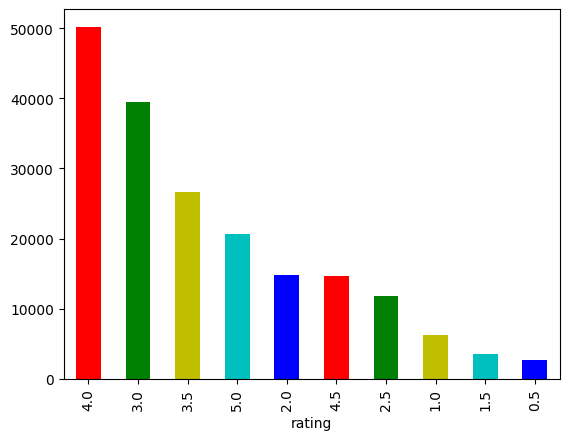

In [29]:
import matplotlib.pyplot as plt
ratings.rating.value_counts().plot(kind='bar', color=['r', 'g', 'y', 'c', 'b']);
plt.show()

In [30]:
df = ratings[['userId', 'movieId', 'rating']]
df.tail()

,userId,movieId,rating
190616,138493,288,5.0
190617,138493,1748,5.0
190618,138493,616,4.0
190619,138493,1597,4.5
190620,138493,7371,5.0


In [31]:
df = df.merge(movies[['movieId', 'title']])
df.head()

,userId,movieId,rating,title
0,11,7481,5.0,Enemy Mine (1985)
1,11,1046,4.5,Beautiful Thing (1996)
2,11,616,4.0,"Aristocats, The (1970)"
3,11,3535,2.0,American Psycho (2000)
4,11,5669,5.0,Bowling for Columbine (2002)


### Números de usuários e número de itens

In [32]:
print(
"""
Número de usuários: {}
Número de itens: {}
Número de interações: {}
""".format(
    df.userId.nunique(),
    df.movieId.nunique(),
    df.shape[0]
)
)


Número de usuários: 11090
Número de itens: 417
Número de interações: 190621



### Mapeamento em idx

In [33]:
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}

In [34]:
df['userId'] = df['userId'].map(map_users)
df['movieId'] = df['movieId'].map(map_items)
df.head()

,userId,movieId,rating,title
0,0,0,5.0,Enemy Mine (1985)
1,0,1,4.5,Beautiful Thing (1996)
2,0,2,4.0,"Aristocats, The (1970)"
3,0,3,2.0,American Psycho (2000)
4,0,4,5.0,Bowling for Columbine (2002)


In [35]:
map_title = {}

for _, row in df.iterrows():
    map_title[row.movieId] = row.title

In [36]:
print(len(map_title))
print(map_title[100])

417
Send Me No Flowers (1964)


In [37]:
# qtd interações dos usuários
df.groupby('userId').count()

,movieId,rating,title
userId,,,
0,13,13,13
1,14,14,14
2,15,15,15
3,15,15,15
4,11,11,11
...,...,...,...
11085,16,16,16
11086,11,11,11
11087,13,13,13


### Divisão do dataset

In [38]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=2)
train.to_csv('train.txt', index=False, header=False, sep='\t')
test.to_csv('test.txt', index=False, header=False, sep='\t')

In [39]:
! ls -l

total 135024
-rw-rw-r-- 1 coqzieiro coqzieiro    98940 ago 22 09:50  Aula01_Exercicios.ipynb
drwxr-xr-x 2 coqzieiro coqzieiro     4096 mar 17  2022  dataset
-rw-rw-r-- 1 coqzieiro coqzieiro 65019041 ago 22 09:53 'ml-20m-compact.tar (1).gz'
-rw-rw-r-- 1 coqzieiro coqzieiro 65019041 ago 22 09:48  ml-20m-compact.tar.gz
-rw-rw-r-- 1 coqzieiro coqzieiro   647016 ago 22 09:51  out_mp_pred.txt
-rw-rw-r-- 1 coqzieiro coqzieiro  1491068 ago 22 09:53  test.txt
-rw-rw-r-- 1 coqzieiro coqzieiro  5966209 ago 22 09:53  train.txt


In [40]:
print('No. items: ' + str(train['movieId'].nunique()))
print('No. users: ' + str(train['userId'].nunique()))

No. items: 405
No. users: 11090


### Recomendadores

## Prever notas

In [41]:
from caserec.recommenders.rating_prediction.most_popular import MostPopular

In [42]:
MostPopular('train.txt', 'test.txt', 'out_mp_pred.txt').compute()

[Case Recommender: Rating Prediction > Most Popular]

train data:: 11090 users and 405 items (152496 interactions) | sparsity:: 96.60%
test data:: 10571 users and 331 items (38125 interactions) | sparsity:: 98.91%

prediction_time:: 73.864424 sec


Eval:: MAE: 0.701356 RMSE: 0.908405 


In [43]:
df_pred = pd.read_csv('out_mp_pred.txt', sep='\t', names=['userId', 'movieId', 'pred'])
df_pred.head(10)

,userId,movieId,pred
0,0,5,3.340482
1,0,0,3.462625
2,1,13,3.501614
3,1,16,3.075567
4,1,14,3.654597
5,1,19,4.070841
6,1,24,2.841837
7,1,20,3.174392
8,2,21,3.209831
9,3,33,4.192866


In [44]:
test[test.userId == 1]

,userId,movieId,rating,title
13,1,13,5.0,Sliding Doors (1998)
16,1,16,4.0,Rush Hour 2 (2001)
14,1,14,4.0,Go (1999)
21,1,19,5.0,Reservoir Dogs (1992)
26,1,24,3.0,"Deep End of the Ocean, The (1999)"
22,1,20,3.0,While You Were Sleeping (1995)


In [45]:
df_pred = df_pred.merge(test)

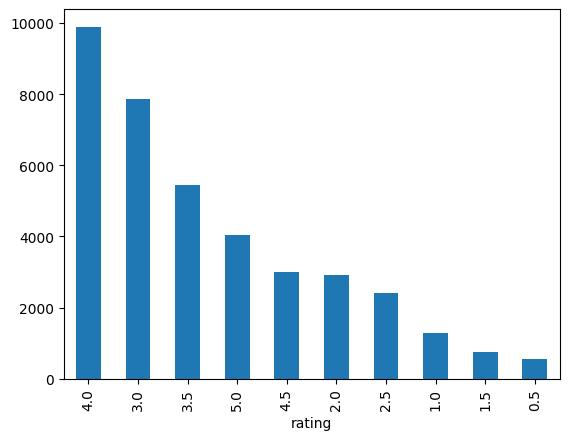

In [46]:
df_pred.rating.value_counts().plot(kind='bar')
plt.show()

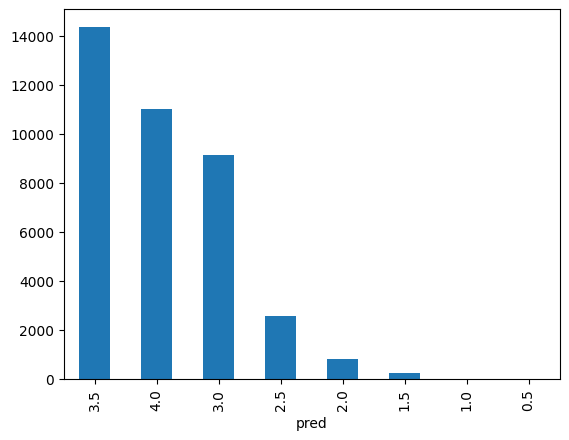

In [47]:
df_pred['pred'] = round(df_pred['pred']*2)/2
df_pred.pred.value_counts().plot(kind='bar');
plt.show()

### Top N

In [48]:
from caserec.recommenders.item_recommendation.most_popular import MostPopular as MPR

In [49]:
MPR('train.txt', 'test.txt', 'out_mp_pred_binary.txt', as_binary=True).compute()

[Case Recommender: Item Recommendation > Most Popular]

train data:: 11090 users and 405 items (152496 interactions) | sparsity:: 96.60%
test data:: 10571 users and 331 items (38125 interactions) | sparsity:: 98.91%

prediction_time:: 1.399469 sec


Eval:: PREC@1: 0.38407 PREC@3: 0.251159 PREC@5: 0.210936 PREC@10: 0.164895 RECALL@1: 0.124528 RECALL@3: 0.229538 RECALL@5: 0.314706 RECALL@10: 0.481962 MAP@1: 0.38407 MAP@3: 0.454719 MAP@5: 0.46042 MAP@10: 0.437819 NDCG@1: 0.38407 NDCG@3: 0.523129 NDCG@5: 0.547547 NDCG@10: 0.554529 


In [50]:
ranking = pd.read_csv('out_mp_pred_binary.txt', sep='\t', names=['userId', 'movieId', 'score'])
ranking['title'] = ranking.movieId.map(map_title)
ranking.head(15)

,userId,movieId,score,title
0,0,19,6444.0,Reservoir Dogs (1992)
1,0,22,4535.0,Natural Born Killers (1994)
2,0,17,4484.0,Chasing Amy (1997)
3,0,18,4356.0,Life Is Beautiful (La Vita è bella) (1997)
4,0,33,3855.0,North by Northwest (1959)
5,0,5,3567.0,"I, Robot (2004)"
6,0,21,3560.0,Conspiracy Theory (1997)
7,0,20,3495.0,While You Were Sleeping (1995)
8,0,23,3482.0,Crimson Tide (1995)
9,0,28,3392.0,My Best Friend's Wedding (1997)


### Item KNN

In [51]:
from caserec.recommenders.rating_prediction.itemknn import ItemKNN

ItemKNN('train.txt', 'test.txt', 'rp_iknn.txt', as_similar_first=True).compute()

[Case Recommender: Rating Prediction > ItemKNN Algorithm]

train data:: 11090 users and 405 items (152496 interactions) | sparsity:: 96.60%
test data:: 10571 users and 331 items (38125 interactions) | sparsity:: 98.91%

training_time:: 4.901317 sec
prediction_time:: 2.000164 sec
Eval:: MAE: 0.663504 RMSE: 0.872175 


**Exercício 01:**

a) Encontrar o id do usuário que avaliou mais filmes na base. Informe o id externo (da base dados) e o interno (usado pelo recomendador)

In [70]:
df = df.copy()
if 'userId_ext' not in df.columns:
    df['userId_ext'] = df['userId']
    df['movieId_ext'] = df['movieId']

# Agora faça/repita o mapeamento:
map_users = {user: idx for idx, user in enumerate(df['userId_ext'].unique())}
map_items = {item: idx for idx, item in enumerate(df['movieId_ext'].unique())}
df['userId'] = df['userId_ext'].map(map_users)      # interno
df['movieId'] = df['movieId_ext'].map(map_items)    # interno

print("Exemplo após preservação:")
print(df[['userId_ext','userId','movieId_ext','movieId','title','rating']].head())

Exemplo após preservação:
   userId_ext  userId  movieId_ext  movieId                         title  \
0           0       0            0        0             Enemy Mine (1985)   
1           0       0            1        1        Beautiful Thing (1996)   
2           0       0            2        2        Aristocats, The (1970)   
3           0       0            3        3        American Psycho (2000)   
4           0       0            4        4  Bowling for Columbine (2002)   

   rating  
0     5.0  
1     4.5  
2     4.0  
3     2.0  
4     5.0  


In [71]:
user_counts = df.groupby(['userId_ext','userId'])['movieId'].count().reset_index(name='qtd')
top_user = user_counts.sort_values('qtd', ascending=False).iloc[0]
print(f"ID externo: {int(top_user.userId_ext)} | ID interno: {int(top_user.userId)} | qtd avaliações: {int(top_user.qtd)}")

ID externo: 9518 | ID interno: 9518 | qtd avaliações: 163


Montamos movie_stats para depois anexar média de nota e número de avaliações às recomendações.

- A matriz UI é o insumo para calcular a similaridade de cosseno entre colunas (itens).

- Em UI_centered subtraímos a média da linha (usuário) para reduzir viés — é exatamente a ideia mostrada na Aula 01.

b) Encontrar os 5 primeiros usuários que têm maior propensão a dar notas baixas aos filmes (use a média de ratings para isso).

In [72]:
user_means = (
    df.groupby(['userId_ext','userId'])['rating']
      .mean()
      .reset_index(name='avg_rating')
      .sort_values(['avg_rating','userId_ext'], ascending=[True, True])
      .head(5)
)
print(user_means)


       userId_ext  userId  avg_rating
9160         9160    9160    0.735294
172           172     172    0.961538
6728         6728    6728    1.115385
8266         8266    8266    1.205882
10835       10835   10835    1.307692


Definimos topk_similares_item. Ele calcula a similaridade de cosseno entre filmes, filtra por mínimo de usuários em comum (min_overlap), junta estatísticas e ordena os resultados. No final imprimimos só a confirmação.

c) Encontrar os 5 filmes pior avaliados pelos usuários.

In [73]:
movie_stats = (
    df.groupby(['movieId','movieId_ext','title'])
      .agg(avg_rating=('rating','mean'), n=('rating','count'))
      .reset_index()
)

min_n = 5  # ajuste se quiser exigir mais evidência
worst5 = (
    movie_stats[movie_stats['n'] >= min_n]
    .sort_values(['avg_rating','n','movieId_ext'], ascending=[True, False, True])
    .head(5)
    .reset_index(drop=True)
)
print(worst5[['movieId_ext','title','avg_rating','n']])

   movieId_ext                                           title  avg_rating  \
0          261                                      DNA (1997)    1.576923   
1           92                 Children of the Corn III (1994)    1.622449   
2           95  Dumb and Dumberer: When Harry Met Lloyd (2003)    1.660670   
3          187                             Theodore Rex (1995)    1.681159   
4          145                     I Know Who Killed Me (2007)    1.716535   

     n  
0   13  
1  245  
2  806  
3   69  
4  127  


Escolhemos como alvo o filme mais avaliado (melhor base de comparação), rodamos a função e imprimimos o Top-10 vizinhos com suas métricas.

**Exercício 02:** Na aula vimos uma abordagem de recomendação não personalizada que utiliza a quantidade de interações dos itens para recomendar filmes mais populares aos usuários. Quando há feedback explícito, entretanto, a mesma abordagem "Most Popular" pode fazer uso da média das notas disponíveis, ou seja, recomendam-se os N filmes mais bem avaliados a cada usuário. Desse modo, calcule a recomendação de 5 filmes para um usuário qualquer da base considerando essa estratégia não personalizada. Utilize a base toda como conjunto de treinamento.

In [75]:
movie_stats_full = (
    df.groupby(['movieId','title'])
      .agg(avg_rating=('rating','mean'), n=('rating','count'))
      .reset_index()
)
top5_global = (
    movie_stats_full
    .sort_values(['avg_rating','n','movieId'], ascending=[False, False, True])
    .head(5)
    .reset_index(drop=True)
)
print(top5_global[['movieId','title','avg_rating','n']])

any_user = int(df['userId'].iloc[0])
print(f"Usuário interno de exemplo: {any_user}")
for i, row in top5_global.iterrows():
    print(f"{i+1}. [{row['movieId']}] {row['title']} — média {row['avg_rating']:.2f} (n={row['n']})")

   movieId                                              title  avg_rating  \
0      367                            Everybody Street (2013)    4.500000   
1       33                          North by Northwest (1959)    4.199626   
2       12  Star Wars: Episode V - The Empire Strikes Back...    4.178017   
3      268                                    Napoléon (1927)    4.107143   
4      167                  Samouraï, Le (Godson, The) (1967)    4.066667   

      n  
0     1  
1  4809  
2  9530  
3    14  
4   375  
Usuário interno de exemplo: 0
1. [367] Everybody Street (2013) — média 4.50 (n=1)
2. [33] North by Northwest (1959) — média 4.20 (n=4809)
3. [12] Star Wars: Episode V - The Empire Strikes Back (1980) — média 4.18 (n=9530)
4. [268] Napoléon (1927) — média 4.11 (n=14)
5. [167] Samouraï, Le (Godson, The) (1967) — média 4.07 (n=375)


Esse Top-5 é o mesmo para qualquer usuário, é uma recomendação não-personalizada baseada na qualidade média.

In [76]:
# escolhemos o primeiro user interno do df apenas para exibir a mensagem
any_user = int(df['userId'].iloc[0])
print(f"Usuário interno de exemplo: {any_user}")

for i, row in top5_global.iterrows():
    print(f"{i+1}. [{row['movieId']}] {row['title']} — média {row['avg_rating']:.2f} (n={row['n']})")

Usuário interno de exemplo: 0
1. [367] Everybody Street (2013) — média 4.50 (n=1)
2. [33] North by Northwest (1959) — média 4.20 (n=4809)
3. [12] Star Wars: Episode V - The Empire Strikes Back (1980) — média 4.18 (n=9530)
4. [268] Napoléon (1927) — média 4.11 (n=14)
5. [167] Samouraï, Le (Godson, The) (1967) — média 4.07 (n=375)


A saída mostra o Top-5 global junto com a média e o número de avaliações, é exatamente a estratégia “Most Popular (por nota)”.

**Exercício 03:** Com base no código disponível no notebook "Aula01_Exemplos.ipynb", implemente uma função que retorna os k filmes mais similares a um outro qualquer passado como parâmetro. 

In [77]:
UI = df.pivot_table(index='userId', columns='movieId', values='rating', aggfunc='mean')
UI_centered = UI.sub(UI.mean(axis=1), axis=0)
print(f"Dimensões: usuários={UI.shape[0]}, filmes={UI.shape[1]}")
print(UI_centered.iloc[:3, :5])


Dimensões: usuários=11090, filmes=417
movieId         0         1         2         3         4
userId                                                   
0        0.615385  0.115385 -0.384615 -2.384615  0.615385
1             NaN       NaN       NaN  0.071429       NaN
2             NaN       NaN       NaN       NaN       NaN


Criamos UI e UI_centered como na Aula 01. A centralização ajuda o cosseno a refletir padrões de preferência (acima/abaixo da média do usuário).

In [78]:
from sklearn.metrics.pairwise import cosine_similarity

def topk_similares_item(
    movie_id_int,
    k=10,
    min_overlap=3,
    centered_matrix=UI_centered,
    raw_matrix=UI,
    stats=movie_stats_full  # pode ser movie_stats, são equivalentes aqui
):
    if movie_id_int not in centered_matrix.columns:
        raise ValueError("Filme-alvo não está na matriz.")

    target = centered_matrix[[movie_id_int]].fillna(0)
    sims = cosine_similarity(centered_matrix.fillna(0).T, target.T).ravel()
    sim_df = pd.DataFrame({'movieId': centered_matrix.columns, 'sim': sims})
    sim_df = sim_df[sim_df['movieId'] != movie_id_int]

    overlap = (
        raw_matrix.notna().astype(int)
        .T.dot(raw_matrix[movie_id_int].notna().astype(int))
        .rename('overlap').reset_index().rename(columns={'index':'movieId'})
    )
    sim_df = sim_df.merge(overlap, on='movieId', how='left')
    sim_df = sim_df[sim_df['overlap'] >= min_overlap]

    sim_df = sim_df.merge(stats, on='movieId', how='left')
    sim_df = (sim_df.sort_values(['sim','overlap','n'], ascending=[False, False, False])
                   .head(k)[['movieId','title','sim','overlap','avg_rating','n']]
                   .reset_index(drop=True))
    return sim_df


Calculamos a similaridade de cosseno entre colunas (filmes), exigimos um mínimo de co-avaliações e apresentamos os vizinhos com título, média e contagem.

In [79]:
movie_target = movie_stats_full.sort_values('n', ascending=False).iloc[0]['movieId']
movie_title  = movie_stats_full.loc[movie_stats_full['movieId']==movie_target, 'title'].iloc[0]
print(f"Filme alvo (id interno): {int(movie_target)} — {movie_title}")

vizinhos = topk_similares_item(movie_target, k=10, min_overlap=3)
print("Top-10 similares:")
print(vizinhos)

Filme alvo (id interno): 12 — Star Wars: Episode V - The Empire Strikes Back (1980)
Top-10 similares:
   movieId                                              title       sim  \
0       19                              Reservoir Dogs (1992)  0.387021   
1       33                          North by Northwest (1959)  0.322571   
2       18         Life Is Beautiful (La Vita è bella) (1997)  0.208106   
3       10                                   Dark City (1998)  0.202970   
4       30                                  Collateral (2004)  0.165485   
5       34                               Roman Holiday (1953)  0.143222   
6       80  Fog of War: Eleven Lessons from the Life of Ro...  0.130304   
7        4                       Bowling for Columbine (2002)  0.130289   
8       38                     Guardians of the Galaxy (2014)  0.115949   
9       46                         Straight Story, The (1999)  0.115886   

   overlap  avg_rating     n  
0     7056    4.061329  8006  
1     4323

Rodamos um caso concreto (alvo popular) para você já visualizar a lista de similares e verificar se faz sentido (mesmo gênero/época/elenco etc.).